In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np

import theano

import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2023-02-16 19:00:39.429260


In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300

def plot_label_resizer(axes, fontsize=14):
    """Resizes the axes labels of plots"""
    for ax in axes.ravel():
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
    return

In [3]:
penguins = pd.read_csv("../data/penguins.csv")

# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)

# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [4]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

In [5]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"]

with pm.Model() as model_adelie_flipper_regression:
    # pm.Data allows us to change the underlying value in a later code block
    adelie_flipper_length = pm.Data("adelie_flipper_length", adelie_flipper_length_obs)
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    inf_data_adelie_flipper_regression = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_1, β_0, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7148414073994275, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8848296292476576, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [6]:
df_sum = az.summary(inf_data_adelie_flipper_regression)
df_sum.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0,-2332.661,940.608,-4193.325,-657.985,29.146,21.110,1042.0,1020.0,1.01
β_1,31.761,4.942,22.770,41.239,0.152,0.109,1060.0,1068.0,1.01
σ,409.538,24.778,360.211,451.216,1.043,0.738,506.0,133.0,1.00
μ[0],3416.142,56.527,3308.526,3519.012,1.535,1.086,1363.0,1624.0,1.01
μ[1],3574.949,39.442,3502.073,3648.511,0.852,0.602,2139.0,2811.0,1.00


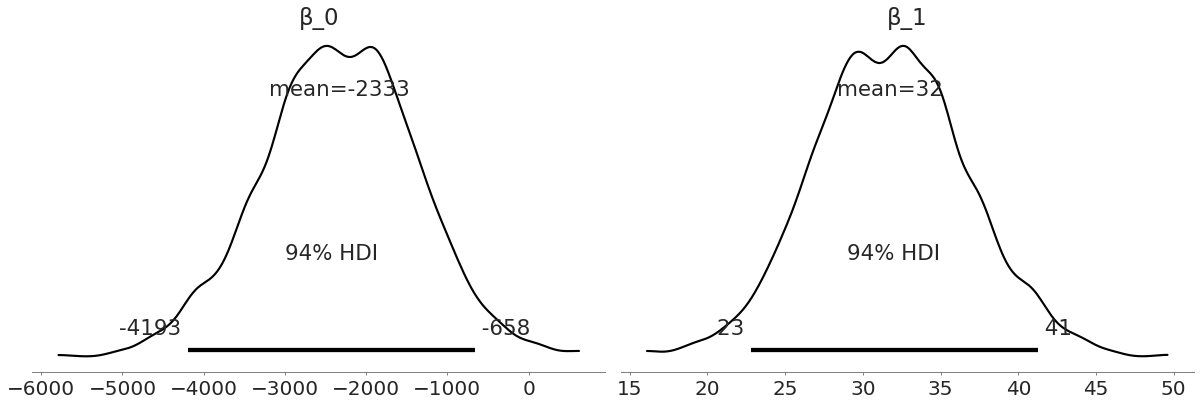

In [7]:
axes = az.plot_posterior(inf_data_adelie_flipper_regression, var_names = ["β_0", "β_1"], textsize=20);

#plot_label_resizer(axes, fontsize)
# plt.savefig("img/chp03/adelie_coefficient_posterior_plots")

<AxesSubplot:xlabel='β_0', ylabel='β_1'>

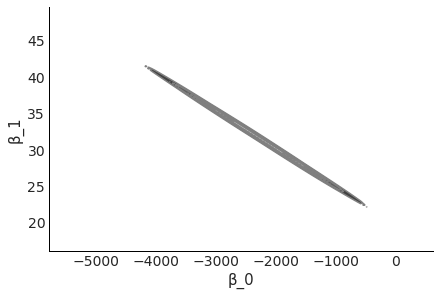

In [8]:
# the two variables are highly correlated !!

az.plot_pair(inf_data_adelie_flipper_regression, var_names=["β_0", "β_1"], kind="kde")

(3000.0, 4750.0)

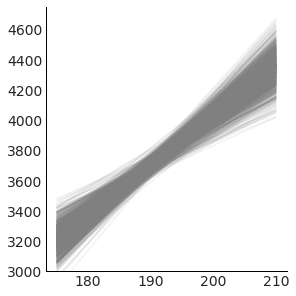

In [11]:
# this is essentially the plot they have, each line is an MCMC sample
# notice though that I can't mix b0 from the first sample with b1 from the second sample
# the posterior samples for the different parameters are not independent !!

fig, ax = plt.subplots(figsize=(4, 4))

# 4000 samples
beta0 = inf_data_adelie_flipper_regression.posterior['β_0'].data.flatten()
beta1 = inf_data_adelie_flipper_regression.posterior['β_1'].data.flatten()

xs = np.linspace(175, 210, 50)

# we are just plotting the first chain but could just as well plot all here
for i in range(1000):
    ax.plot(xs, beta0[i] + beta1[i] * xs, alpha=0.1, color='grey')
ax.set_ylim(3000, 4750)

(3000.0, 4750.0)

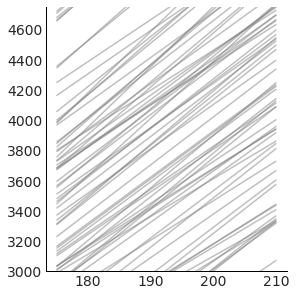

In [10]:
# this is what the posterior would look like if b0 and b1 were independent

fig, ax = plt.subplots(figsize=(4, 4))

beta0 = np.random.normal(df_sum['mean'][0], df_sum['sd'][0], 100)
beta1 = np.random.normal(df_sum['mean'][1], df_sum['sd'][1], 100)

xs = np.linspace(175, 210, 50)

for i in range(100):
    ax.plot(xs, beta0[i] + beta1[i] * xs, alpha=0.5, color='grey')
ax.set_ylim(3000, 4750)

(3000.0, 4750.0)

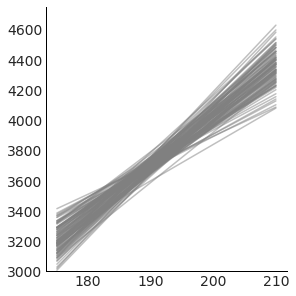

In [14]:
# we can simulate the actual posterior by using a multivariate normal distribution 
# with the right covariance matrix

fig, ax = plt.subplots(figsize=(4, 4))

cov = np.cov(np.array([beta0, beta1]))
betas = stats.multivariate_normal([df_sum['mean'][0], df_sum['mean'][1]], cov).rvs(100)

xs = np.linspace(175, 210, 50)

for i in range(100):
    ax.plot(xs, betas[i][0] + betas[i][1] * xs, alpha=0.5, color='grey')
ax.set_ylim(3000, 4750)